<a href="https://colab.research.google.com/github/Erlan1978/credit_risk/blob/main/credit_risk_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import pyarrow.parquet as pq
import os
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
import xgboost as xgb

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from google.colab import drive
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


# 1 Загрузка данных

Распакуем один файл и посмотрим на его структуру.

In [ ]:
# для работающих в Google Colab
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Загрузка и распаковка файла train_data_0.pq
file_path = '/content/drive/MyDrive/Colab Notebooks/train_data/train_data_0.pq'
table = pq.read_table(file_path)
df = table.to_pandas()

df.head()

id  rn  pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
0   0   1                18                    9          2          3   
1   0   2                18                    9         14         14   
2   0   3                18                    9          4          8   
3   0   4                 4                    1          9         12   
4   0   5                 5                   12         15          2   

   pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
0               16               10                      11   
1               12               12                       0   
2                1               11                      11   
3               16                7                      12   
4               11               12                      10   

   pre_loans_next_pay_summ  ...  enc_paym_21  enc_paym_22  enc_paym_23  \
0                        3  ...            3            3            3   
1                        3  ...            0            0            0   
2                        0  ...            0            0            0   
3                        2  ...            3            3            3   
4                        2  ...            3            3            3   

   enc_paym_24  enc_loans_account_holder_type  enc_loans_credit_status  \
0            4                              1                        3   
1            4                              1                        3   
2            4                              1                        2   
3            4                              1                        3   
4            4                              1                        3   

   enc_loans_credit_type  enc_loans_account_cur  pclose_flag  fclose_flag  
0                      4                      1            0            0  
1                      4                      1            0            0  
2                      3                      1            1            1  
3                      1                      1            0            0  
4                      4                      1            0            0  

[5 rows x 61 columns]

Атрибуты данных

id — идентификатор заявки. Заявки пронумерованы так, что большему номеру соответствует более поздняя дата заявки.

rn — порядковый номер кредитного продукта в кредитной истории. Большему номеру соответствует продукт с более поздней датой открытия.

pre_since_opened — количество дней с даты открытия кредита до даты сбора данных (бинаризовано*).

pre_since_confirmed — количество дней с даты подтверждения информации по кредиту до даты сбора данных (бинаризовано*).

pre_pterm — плановое количество дней с даты открытия кредита до даты закрытия (бинаризовано*).

pre_fterm — фактическое количество дней с даты открытия кредита до даты закрытия (бинаризовано*).

pre_till_pclose — плановое количество дней с даты сбора данных до даты закрытия кредита (бинаризовано*).

pre_till_fclose — фактическое количество дней с даты сбора данных до даты закрытия кредита (бинаризовано*).

pre_loans_credit_limit — кредитный лимит (бинаризовано*).

pre_loans_next_pay_summ — сумма следующего платежа по кредиту (бинаризовано*).

pre_loans_outstanding — оставшаяся невыплаченная сумма кредита (бинаризовано*).

pre_loans_total_oÜerdue — текущая просроченная "адолженность (бинаризовано*).

pre_loans_max_oÜerdue_sum — максимальная просроченная задолженность (бинаризовано*).

pre_loans_credit_cost_rate — полная стоимость кредита (бинаризовано*).

pre_loans5 — число просрочек до 5 дней (бинаризовано*).

pre_loans530 — число просрочек от 5 до 30 дней (бинаризовано*).

pre_loans3060 — число просрочек от 30 до 60 дней (бинаризовано*).

pre_loans6090 — число просрочек от 60 до 90 дней (бинаризовано*).

pre_loans90 — число просрочек более чем на 90 дней (бинаризовано*).

is_zero_loans_5 — флаг: нет просрочек до 5 дней.

is_zero_loans_530 — флаг: нет просрочек от 5 до 30 дней.

is_zero_loans_3060 — флаг: нет просрочек от 30 до 60 дней.

is_zero_loans_6090 — флаг: нет просрочек от 60 до 90 дней.

is_zero_loans90 — флаг: нет просрочек более чем на 90 дней.

pre_util — отношение оставшейся невыплаченной суммы кредита к кредитному лимиту (бинаризовано*).

pre_over2limit — отношение текущей просроченной задолженности к кредитному лимиту (бинаризовано*)

pre_maxover2limit — отношение максимальной просроченной задолженности к кредитному лимиту (бинаризовано*).

is_zero_util — флаг: отношение оставшейся невыплаченной суммы кредита к кредитному лимиту равно 0.

is_zero_over2limit — флаг: отношение текущей просроченной задолженности к кредитному лимиту равно 0.

is_zero_maxover2limit — флаг: отношение максимальной просроченной задолженности к кредитному лимиту равно 0.

enc_paym_{0..N} — статусы ежемесячных платежей за последние N месяцев (закодировано**).

enc_loans_account_holder_type — тип отношения к кредиту (закодировано**).

enc_loans_credit_status — статус кредита (закодировано**).

enc_loans_account_cur — валюта кредита (закодировано**).

enc_loans_credit_type — тип кредита (закодировано**).

pclose_flag — флаг: плановое количество дней с даты открытия кредита до даты закрытия не определено.

fclose_flag — флаг: фактическое количество дней с даты открытия кредита до даты закрытия не определено.

* Область значений поля разбивается на N непересекающихся промежутков. Каждому промежутку случайным образом назначается уникальный номер от 0 до N-1E а значение поля заменяется номером промежуткаE которому оно принадлежит

In [ ]:
df.shape

(1974724, 61)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1974724 entries, 0 to 1974723
Data columns (total 61 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   rn                             int64
 2   pre_since_opened               int64
 3   pre_since_confirmed            int64
 4   pre_pterm                      int64
 5   pre_fterm                      int64
 6   pre_till_pclose                int64
 7   pre_till_fclose                int64
 8   pre_loans_credit_limit         int64
 9   pre_loans_next_pay_summ        int64
 10  pre_loans_outstanding          int64
 11  pre_loans_total_overdue        int64
 12  pre_loans_max_overdue_sum      int64
 13  pre_loans_credit_cost_rate     int64
 14  pre_loans5                     int64
 15  pre_loans530                   int64
 16  pre_loans3060                  int64
 17  pre_loans6090                  int64
 18  pre_loans90                    int64
 19  


1.1 Код для базового сбора признаков и прочтения датасета.

In [ ]:
def read_parquet_dataset_from_local(path_to_dataset: str, start_from: int = 0,
                                     num_parts_to_read: int = 2, columns=None, verbose=False) -> pd.DataFrame:
    """
    читает num_parts_to_read партиций, преобразовывает их к pd.DataFrame и возвращает
    :param path_to_dataset: путь до директории с партициями
    :param start_from: номер партиции, с которой нужно начать чтение
    :param num_parts_to_read: количество партиций, которые требуется прочитать
    :param columns: список колонок, которые нужно прочитать из партиции
    :return: pd.DataFrame
    """

    res = []
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                              if filename.startswith('train')])
    print(dataset_paths)

    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for chunk in chunks:
            print(chunk)
    for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):
        print('chunk_path', chunk_path)
        chunk = pd.read_parquet(chunk_path,columns=columns)
        res.append(chunk)

    return pd.concat(res).reset_index(drop=True)

In [ ]:
def prepare_transactions_dataset(path_to_dataset: str, num_parts_to_preprocess_at_once: int = 1, num_parts_total: int=50,
                                 save_to_path=None, verbose: bool=False):
    """
    возвращает готовый pd.DataFrame с признаками, на которых можно учить модель для целевой задачи
    path_to_dataset: str
        путь до датасета с партициями
    num_parts_to_preprocess_at_once: int
        количество партиций, которые будут одновременно держаться и обрабатываться в памяти
    num_parts_total: int
        общее количество партиций, которые нужно обработать
    save_to_path: str
        путь до папки, в которой будет сохранён каждый обработанный блок в .parquet-формате; если None, то не будет сохранён
    verbose: bool
        логирует каждую обрабатываемую часть данных
    """
    preprocessed_frames = []

    for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                                   desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once,
                                                             verbose=verbose)
   #записываем подготовленные данные в файл
        if save_to_path:
            block_as_str = str(step)
            if len(block_as_str) == 1:
                block_as_str = '00' + block_as_str
            else:
                block_as_str = '0' + block_as_str
            transactions_frame.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))

        preprocessed_frames.append(transactions_frame)
    return pd.concat(preprocessed_frames)

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/train_data'

In [ ]:
# Создаем директорию 'train_data/' в корневой папке Google Drive
os.makedirs('/content/drive/MyDrive/Colab Notebooks/train_data/', exist_ok=True)

In [ ]:
path_to_save = '/content/drive/MyDrive/Colab Notebooks/train_data/'
data = prepare_transactions_dataset(path, num_parts_to_preprocess_at_once=2, num_parts_total=2,
                                    save_to_path=path_to_save)

<ipython-input-7-737267b664bf>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),


Transforming transactions data:   0%|          | 0/1 [00:00<?, ?it/s]

['/content/drive/MyDrive/Colab Notebooks/train_data/train_data_0.pq', '/content/drive/MyDrive/Colab Notebooks/train_data/train_data_1.pq', '/content/drive/MyDrive/Colab Notebooks/train_data/train_data_10.pq', '/content/drive/MyDrive/Colab Notebooks/train_data/train_data_11.pq', '/content/drive/MyDrive/Colab Notebooks/train_data/train_data_2.pq', '/content/drive/MyDrive/Colab Notebooks/train_data/train_data_3.pq', '/content/drive/MyDrive/Colab Notebooks/train_data/train_data_4.pq', '/content/drive/MyDrive/Colab Notebooks/train_data/train_data_5.pq', '/content/drive/MyDrive/Colab Notebooks/train_data/train_data_6.pq', '/content/drive/MyDrive/Colab Notebooks/train_data/train_data_7.pq', '/content/drive/MyDrive/Colab Notebooks/train_data/train_data_8.pq', '/content/drive/MyDrive/Colab Notebooks/train_data/train_data_9.pq']


<ipython-input-6-8d132f0cbd2b>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

chunk_path /content/drive/MyDrive/Colab Notebooks/train_data/train_data_0.pq
chunk_path /content/drive/MyDrive/Colab Notebooks/train_data/train_data_1.pq


In [ ]:
# Количество строк
data.shape

(4082029, 61)

In [ ]:
# значения целевой переменной (смерджить с фичами по id)
targets = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train_target.csv')
targets.head()

id  flag
0   0     0
1   1     0
2   2     0
3   3     0
4   4     0

In [ ]:
data.tail()

id  rn  pre_since_opened  pre_since_confirmed  pre_pterm  \
4082024  499999   8                 6                   11         14   
4082025  499999   9                11                   13         17   
4082026  499999  10                 1                    2         11   
4082027  499999  11                12                   10          1   
4082028  499999  12                12                    2          6   

         pre_fterm  pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
4082024          7               12               11                      15   
4082025         16                8                8                      15   
4082026          8                8               11                      11   
4082027          8               14               11                       8   
4082028          8                0               11                       2   

         pre_loans_next_pay_summ  ...  enc_paym_21  enc_paym_22  enc_paym_23  \
4082024                        2  ...            0            0            3   
4082025                        2  ...            3            3            3   
4082026                        2  ...            3            3            3   
4082027                        1  ...            3            3            3   
4082028                        5  ...            3            3            3   

         enc_paym_24  enc_loans_account_holder_type  enc_loans_credit_status  \
4082024            4                              1                        3   
4082025            4                              1                        3   
4082026            4                              1                        2   
4082027            4                              1                        2   
4082028            4                              1                        2   

         enc_loans_credit_type  enc_loans_account_cur  pclose_flag  \
4082024                      2                      1            0   
4082025                      2                      1            0   
4082026                      3                      1            0   
4082027                      4                      1            0   
4082028                      0                      1            0   

         fclose_flag  
4082024            0  
4082025            0  
4082026            1  
4082027            1  
4082028            1  

[5 rows x 61 columns]

In [ ]:
# Получаем список уникальных идентификаторов
unique_ids = data['id'].unique()

# Случайным образом выбираем 3000000 строк из датасета
sampled_data = data[data['id'].isin(unique_ids)].sample(n=3000000, replace=False)

In [ ]:
print('Количество строк в id', len(sampled_data.id))

Количество строк в id 3000000


In [ ]:
sampled_data.tail()

id  rn  pre_since_opened  pre_since_confirmed  pre_pterm  \
1174299  150073   4                13                    9          7   
1550639  197728   2                 4                    0         11   
3029198  377084   8                 7                   10         14   
1145243  146469   1                 6                    9          4   
3269692  405614   7                10                    9         14   

         pre_fterm  pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
1174299          6               13                5                      12   
1550639          8                1               11                       4   
3029198          7               10                4                      14   
1145243         13                1                0                      10   
3269692          5               11               13                      15   

         pre_loans_next_pay_summ  ...  enc_paym_21  enc_paym_22  enc_paym_23  \
1174299                        3  ...            3            3            3   
1550639                        2  ...            3            3            3   
3029198                        3  ...            3            3            3   
1145243                        1  ...            0            0            0   
3269692                        0  ...            3            3            3   

         enc_paym_24  enc_loans_account_holder_type  enc_loans_credit_status  \
1174299            4                              1                        3   
1550639            4                              1                        2   
3029198            4                              1                        2   
1145243            4                              1                        3   
3269692            4                              1                        3   

         enc_loans_credit_type  enc_loans_account_cur  pclose_flag  \
1174299                      4                      1            0   
1550639                      3                      1            0   
3029198                      4                      1            0   
1145243                      3                      1            1   
3269692                      4                      1            0   

         fclose_flag  
1174299            0  
1550639            1  
3029198            0  
1145243            0  
3269692            0  

[5 rows x 61 columns]

In [ ]:
# Сортируем выборку по возрастанию идентификаторов
sampled_data_sorted = sampled_data.sort_values(by='id')
sampled_data_sorted.head()

id  rn  pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
0    0   1                18                    9          2          3   
1    0   2                18                    9         14         14   
9    0  10                 7                    9          2         10   
3    0   4                 4                    1          9         12   
22   1  13                 7                    9          4          8   

    pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
0                16               10                      11   
1                12               12                       0   
9                 8                8                      16   
3                16                7                      12   
22                1               11                       1   

    pre_loans_next_pay_summ  ...  enc_paym_21  enc_paym_22  enc_paym_23  \
0                         3  ...            3            3            3   
1                         3  ...            0            0            0   
9                         4  ...            3            3            3   
3                         2  ...            3            3            3   
22                        1  ...            3            3            3   

    enc_paym_24  enc_loans_account_holder_type  enc_loans_credit_status  \
0             4                              1                        3   
1             4                              1                        3   
9             4                              1                        2   
3             4                              1                        3   
22            4                              1                        2   

    enc_loans_credit_type  enc_loans_account_cur  pclose_flag  fclose_flag  
0                       4                      1            0            0  
1                       4                      1            0            0  
9                       4                      1            0            0  
3                       1                      1            0            0  
22                      3                      1            1            1  

[5 rows x 61 columns]

In [ ]:
# Выведим последние 100 строк
sampled_data_sorted.tail(100)

id  rn  pre_since_opened  pre_since_confirmed  pre_pterm  \
4081895  499979   2                 9                   16          0   
4081896  499979   3                 7                    6          4   
4081898  499980   1                 8                    7          8   
4081904  499980   7                13                   14         15   
4081902  499980   5                15                    7          8   
...         ...  ..               ...                  ...        ...   
4082018  499999   2                14                    4         15   
4082025  499999   9                11                   13         17   
4082020  499999   4                10                    4          9   
4082019  499999   3                10                    4          8   
4082021  499999   5                10                    6         16   

         pre_fterm  pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
4081895          1                0                4                      17   
4081896          8                1               11                      19   
4081898         11                4                9                      18   
4081904          2                3                5                       8   
4081902          5                9                1                       5   
...            ...              ...              ...                     ...   
4082018         12                6               13                      12   
4082025         16                8                8                      15   
4082020         12                6                3                      17   
4082019         11                6               13                      19   
4082021          9               13                3                      19   

         pre_loans_next_pay_summ  ...  enc_paym_21  enc_paym_22  enc_paym_23  \
4081895                        6  ...            3            3            3   
4081896                        6  ...            3            3            3   
4081898                        2  ...            3            3            3   
4081904                        2  ...            3            3            3   
4081902                        2  ...            3            3            3   
...                          ...  ...          ...          ...          ...   
4082018                        2  ...            3            3            3   
4082025                        2  ...            3            3            3   
4082020                        2  ...            3            3            3   
4082019                        4  ...            3            3            3   
4082021                        1  ...            3            3            3   

         enc_paym_24  enc_loans_account_holder_type  enc_loans_credit_status  \
4081895            4                              1                        2   
4081896            4                              1                        2   
4081898            4                              1                        3   
4081904            4                              1                        3   
4081902            4                              1                        3   
...              ...                            ...                      ...   
4082018            4                              1                        3   
4082025            4                              1                        3   
4082020            4                              1                        3   
4082019            4                              1                        3   
4082021            4                              1                        3   

         enc_loans_credit_type  enc_loans_account_cur  pclose_flag  \
4081895                      3                      1            0   
4081896                      4                      1            1   
4081898                      4             

In [ ]:
# Объединение данных по столбцу 'id'
merged_data = pd.merge(sampled_data_sorted, targets, on='id')
merged_data.head()

id  rn  pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
0   0   1                18                    9          2          3   
1   0   2                18                    9         14         14   
2   0  10                 7                    9          2         10   
3   0   4                 4                    1          9         12   
4   1  13                 7                    9          4          8   

   pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
0               16               10                      11   
1               12               12                       0   
2                8                8                      16   
3               16                7                      12   
4                1               11                       1   

   pre_loans_next_pay_summ  ...  enc_paym_22  enc_paym_23  enc_paym_24  \
0                        3  ...            3            3            4   
1                        3  ...            0            0            4   
2                        4  ...            3            3            4   
3                        2  ...            3            3            4   
4                        1  ...            3            3            4   

   enc_loans_account_holder_type  enc_loans_credit_status  \
0                              1                        3   
1                              1                        3   
2                              1                        2   
3                              1                        3   
4                              1                        2   

   enc_loans_credit_type  enc_loans_account_cur  pclose_flag  fclose_flag  \
0                      4                      1            0            0   
1                      4                      1            0            0   
2                      4                      1            0            0   
3                      1                      1            0            0   
4                      3                      1            1            1   

   flag  
0     0  
1     0  
2     0  
3     0  
4     0  

[5 rows x 62 columns]

In [ ]:
# Количество строк
merged_data.shape

(3000000, 62)

Мы объединили датасет. Количество записей в итоговом датасете — три миллиона.


# 2 Data Science

Корреляционный анализ

In [ ]:
# Выберем первые 10000 строк
cutting_dataset = merged_data.head(10000)
cutting_dataset

id  rn  pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
0        0   1                18                    9          2          3   
1        0   2                18                    9         14         14   
2        0  10                 7                    9          2         10   
3        0   4                 4                    1          9         12   
4        1  13                 7                    9          4          8   
...    ...  ..               ...                  ...        ...        ...   
9995  1760   6                 9                   13          4          8   
9996  1760   2                 8                    7         16          9   
9997  1761   4                17                    9          2         12   
9998  1761   2                 0                   14         11         13   
9999  1761   3                 4                   11         13          0   

      pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
0                  16               10                      11   
1                  12               12                       0   
2                   8                8                      16   
3                  16                7                      12   
4                   1               11                       1   
...               ...              ...                     ...   
9995                1               11                       4   
9996                9                1                      12   
9997                2                0                       8   
9998               16               12                       3   
9999               16                7                      13   

      pre_loans_next_pay_summ  ...  enc_paym_22  enc_paym_23  enc_paym_24  \
0                           3  ...            3            3            4   
1                           3  ...            0            0            4   
2                           4  ...            3            3            4   
3                           2  ...            3            3            4   
4                           1  ...            3            3            4   
...                       ...  ...          ...          ...          ...   
9995                        2  ...            3            3            4   
9996                        2  ...            3            3            4   
9997                        3  ...            3            3            4   
9998                        2  ...            3            3            4   
9999                        2  ...            3            3            4   

      enc_loans_account_holder_type  enc_loans_credit_status  \
0                                 1                        3   
1                                 1                        3   
2                                 1                        2   
3                                 1                        3   
4                                 1                        2   
...                             ...                      ...   
9995                              1                        3   
9996                              1                        3   
9997                              1                        3   
9998                              1                        2   
9999                              1                        3   

      enc_loans_credit_type  enc_loans_account_cur  pclose_flag  fclose_flag  \
0                         4                      1            0            0   
1                         4                      1            0            0   
2                         4                      1            0            0   
3                         1                      1            0            0   
4                         3                      1            1            1   
...                     ...                    ...          ...          ...   
9995        

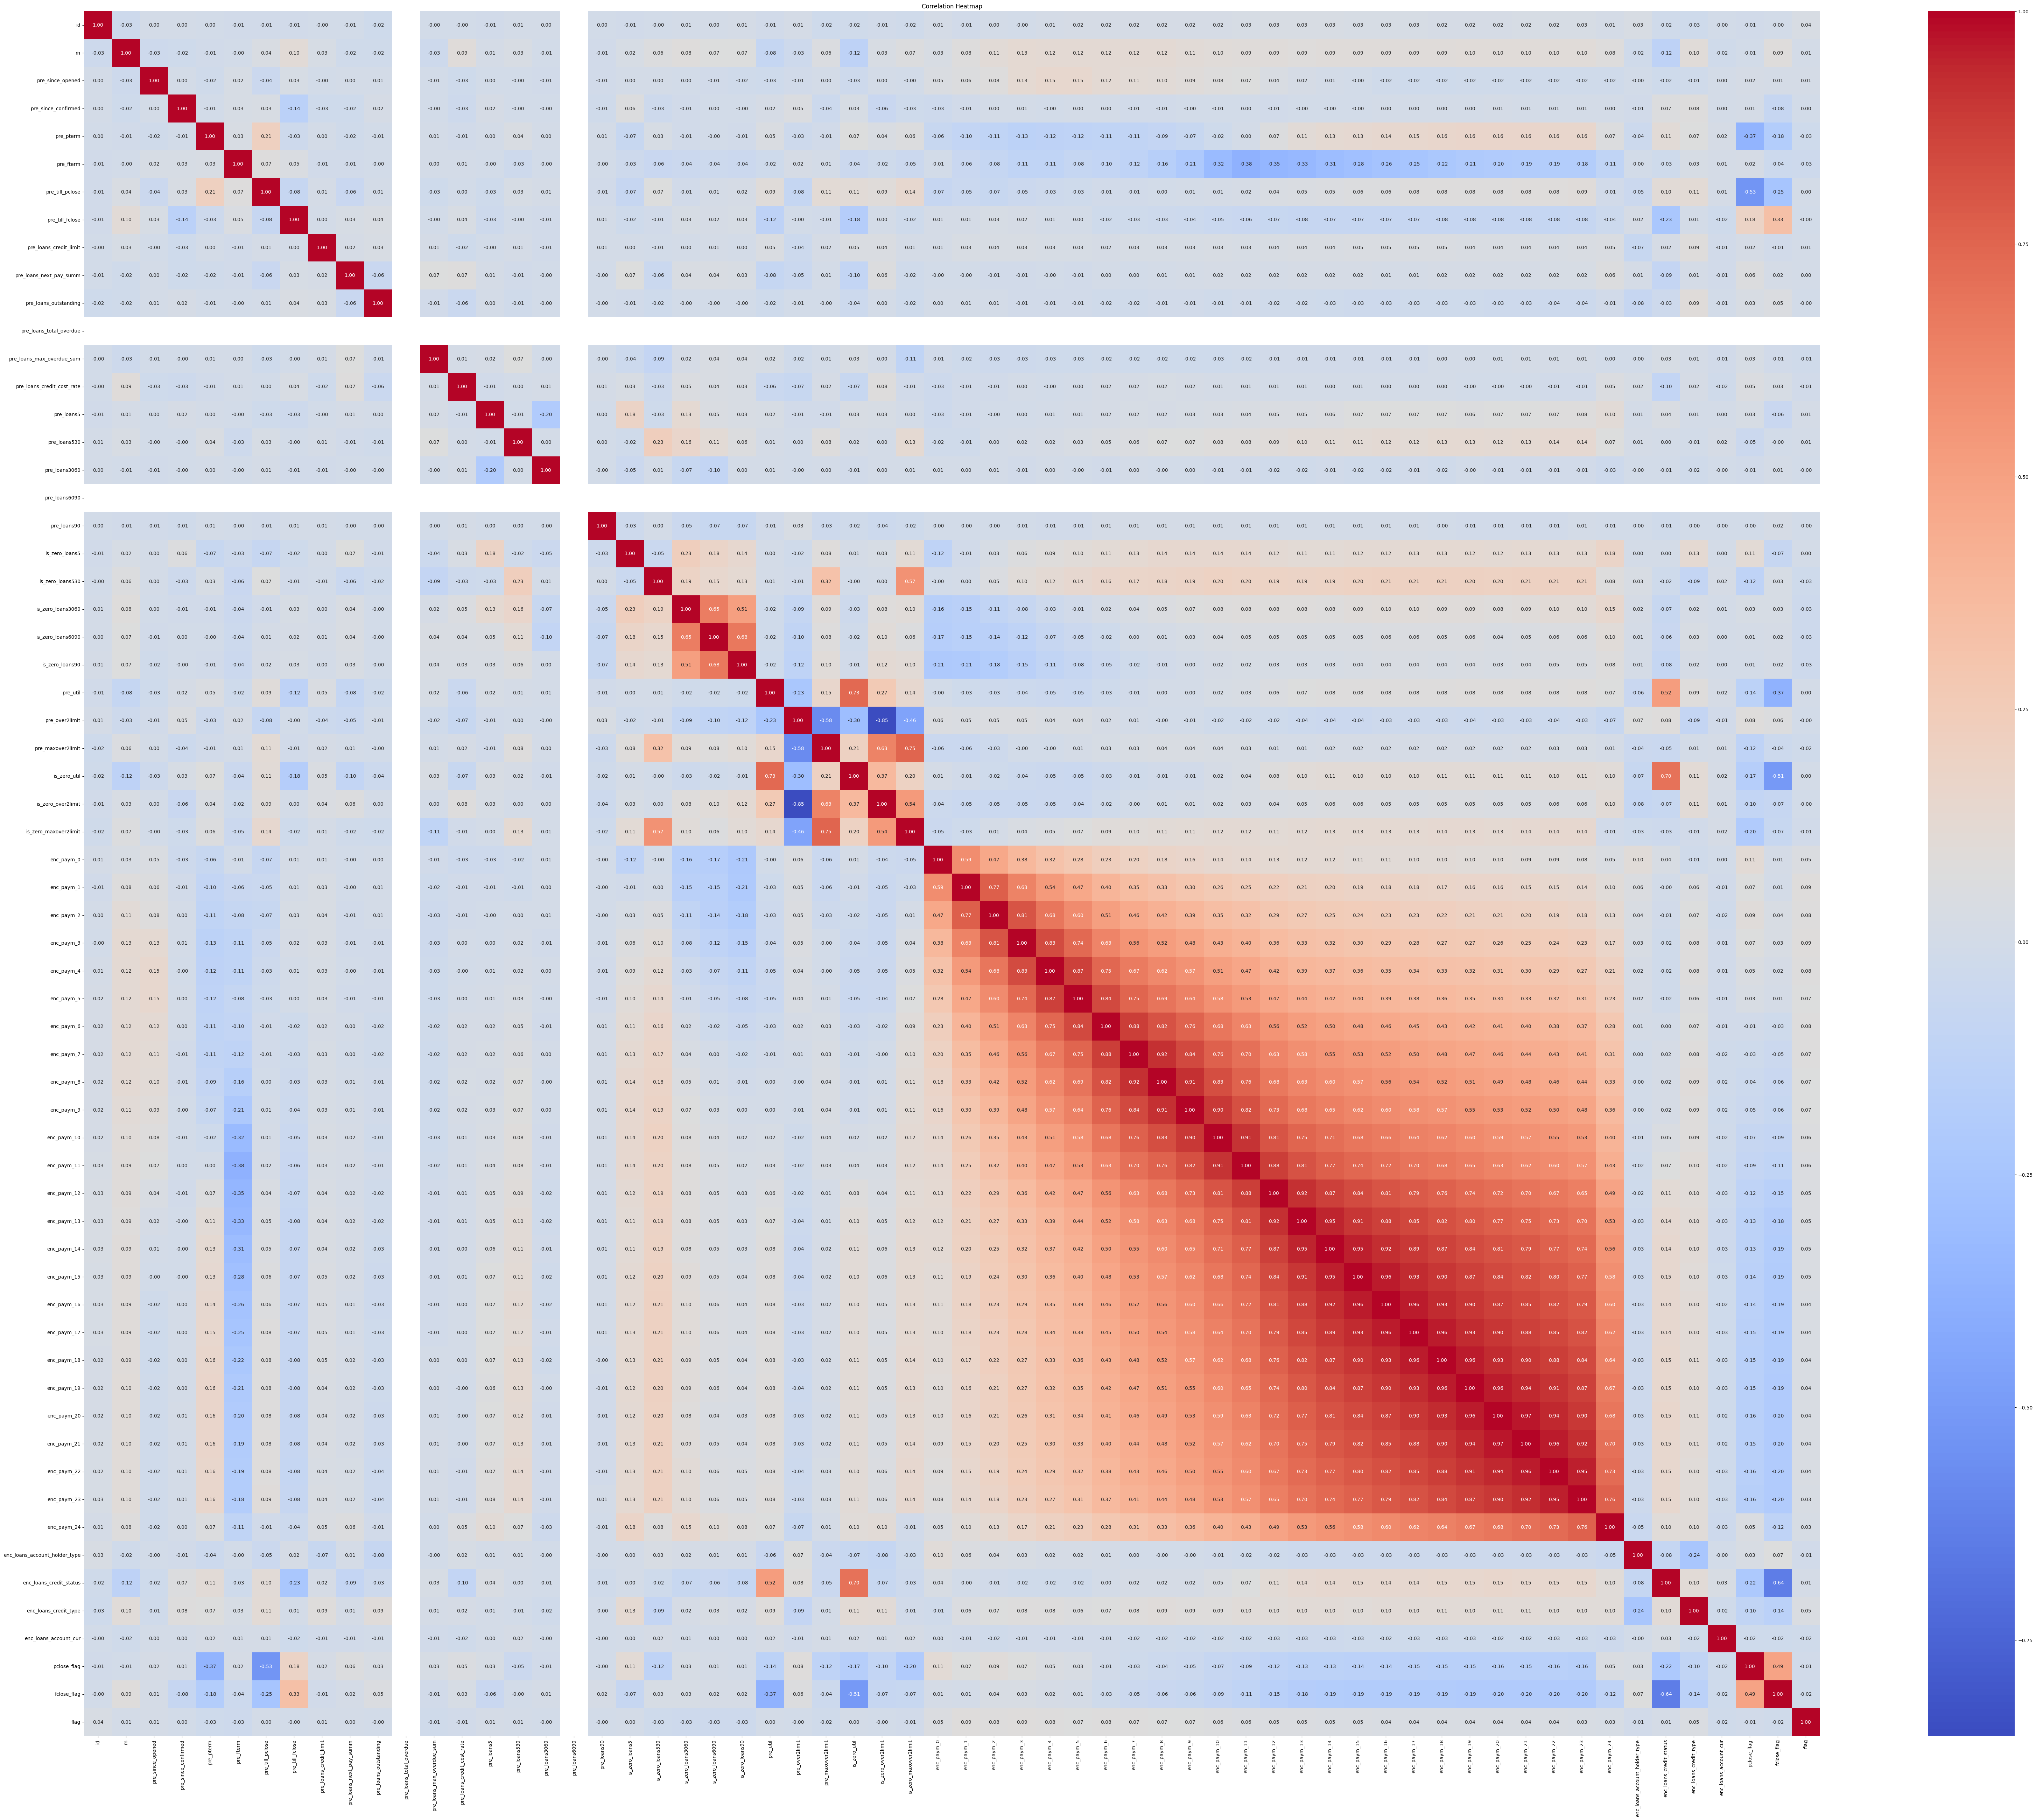

In [ ]:
# Вычисляем матрицу корреляции
corr_matrix = cutting_dataset.corr()

# Создаем тепловую карту
plt.figure(figsize=(80, 64))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Выберем от 10000 до 20000
cutting_dataset_2 = merged_data.iloc[10000:20000]
cutting_dataset_2

id  rn  pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
10000  1761   1                16                   14          4          1   
10001  1762   6                19                    0         17          8   
10002  1762   5                11                    1         16          9   
10003  1762   1                 8                    7         13          2   
10004  1763   2                 0                   16          6          8   
...     ...  ..               ...                  ...        ...        ...   
19995  3547   3                10                    9          8          5   
19996  3547   7                 6                    9         14          7   
19997  3547   5                 6                   14          3          3   
19998  3547   4                 0                    9         14         10   
19999  3547   8                 4                   17         12         15   

       pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
10000                1                5                      19   
10001                8               11                      10   
10002               15                6                      16   
10003                9                1                      12   
10004                0               11                       2   
...                ...              ...                     ...   
19995                6               13                      18   
19996                1               11                      14   
19997                3                5                       6   
19998               11                5                       9   
19999               16               12                      17   

       pre_loans_next_pay_summ  ...  enc_paym_22  enc_paym_23  enc_paym_24  \
10000                        2  ...            0            0            1   
10001                        2  ...            3            3            4   
10002                        2  ...            3            3            4   
10003                        2  ...            3            3            4   
10004                        5  ...            0            0            1   
...                        ...  ...          ...          ...          ...   
19995                        6  ...            3            3            4   
19996                        3  ...            0            0            4   
19997                        2  ...            3            3            4   
19998                        4  ...            0            3            4   
19999                        2  ...            3            3            4   

       enc_loans_account_holder_type  enc_loans_credit_status  \
10000                              1                        3   
10001                              1                        2   
10002                              1                        3   
10003                              1                        3   
10004                              3                        2   
...                              ...                      ...   
19995                              1                        3   
19996                              1                        2   
19997                              1                        3   
19998                              1                        3   
19999                              1                        3   

       enc_loans_credit_type  enc_loans_account_cur  pclose_flag  fclose_flag  \
10000                      3                      1            1            0   
10001                      4                      1            0            1   
10002                      1                      1            0            0   
10003                      4                      1            0            0   
10004                      0                      1            0            1   
...                      ...           

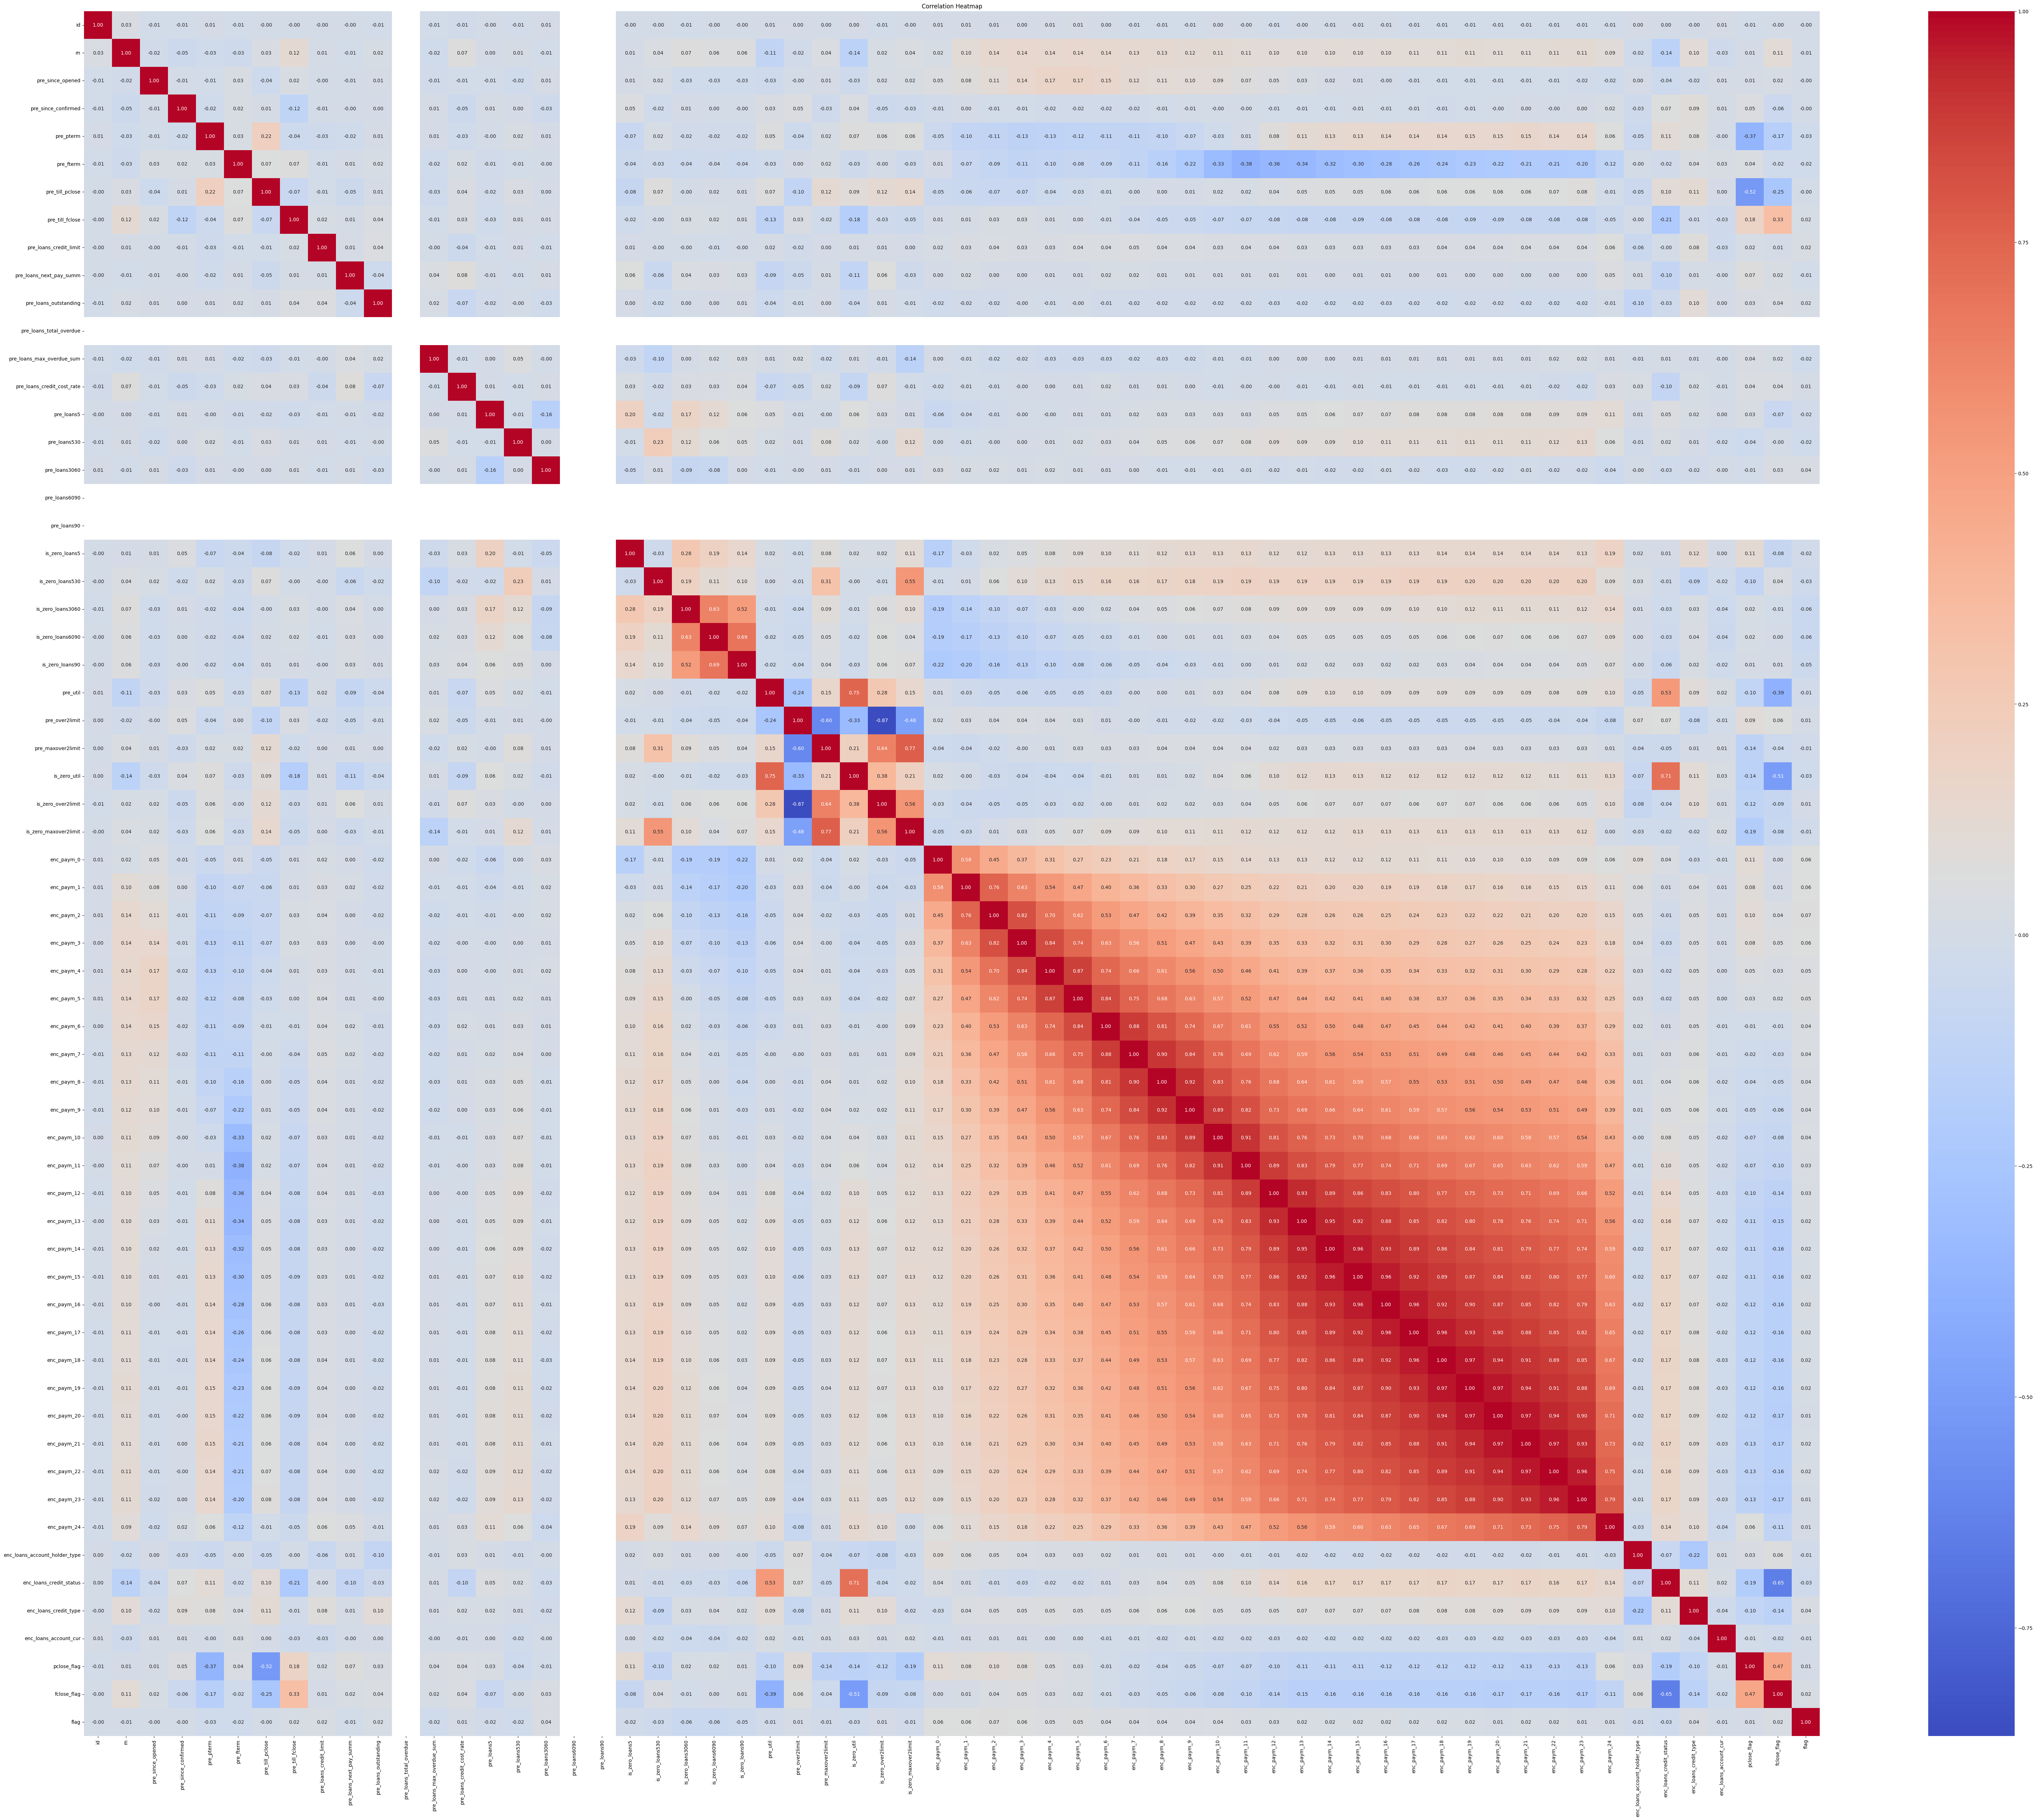

In [ ]:
# Вычисляем матрицу корреляции
corr_matrix = cutting_dataset_2.corr()

# Создаем тепловую карту
plt.figure(figsize=(80, 64))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Выберем первые 10000 строк
cutting_dataset_3 = merged_data.tail(10000)
cutting_dataset_3

id  rn  pre_since_opened  pre_since_confirmed  pre_pterm  \
2990000  498323   3                15                   12          9   
2990001  498323   8                18                   12         12   
2990002  498323   2                15                   12          9   
2990003  498323   5                 0                   12          7   
2990004  498323   4                14                    4         16   
...         ...  ..               ...                  ...        ...   
2999995  499999   2                14                    4         15   
2999996  499999   9                11                   13         17   
2999997  499999   4                10                    4          9   
2999998  499999   3                10                    4          8   
2999999  499999   5                10                    6         16   

         pre_fterm  pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
2990000         12                9               13                       5   
2990001         15               16                7                       1   
2990002         12                9                1                      18   
2990003          2                6                3                       5   
2990004          0                6               13                      19   
...            ...              ...              ...                     ...   
2999995         12                6               13                      12   
2999996         16                8                8                      15   
2999997         12                6                3                      17   
2999998         11                6               13                      19   
2999999          9               13                3                      19   

         pre_loans_next_pay_summ  ...  enc_paym_22  enc_paym_23  enc_paym_24  \
2990000                        2  ...            3            3            4   
2990001                        2  ...            3            3            4   
2990002                        2  ...            3            3            4   
2990003                        2  ...            3            3            4   
2990004                        2  ...            3            3            4   
...                          ...  ...          ...          ...          ...   
2999995                        2  ...            3            3            4   
2999996                        2  ...            3            3            4   
2999997                        2  ...            3            3            4   
2999998                        4  ...            3            3            4   
2999999                        1  ...            3            3            4   

         enc_loans_account_holder_type  enc_loans_credit_status  \
2990000                              1                        3   
2990001                              1                        3   
2990002                              1                        3   
2990003                              1                        3   
2990004                              1                        3   
...                                ...                      ...   
2999995                              1                        3   
2999996                              1                        3   
2999997                              1                        3   
2999998                              1                        3   
2999999                              1                        3   

         enc_loans_credit_type  enc_loans_account_cur  pclose_flag  \
2990000                      1                      1            0   
2990001                      4                      1            0   
2990002                      1                      1            0   
2990003                      1                      1            0   
2990004                      4                      1      

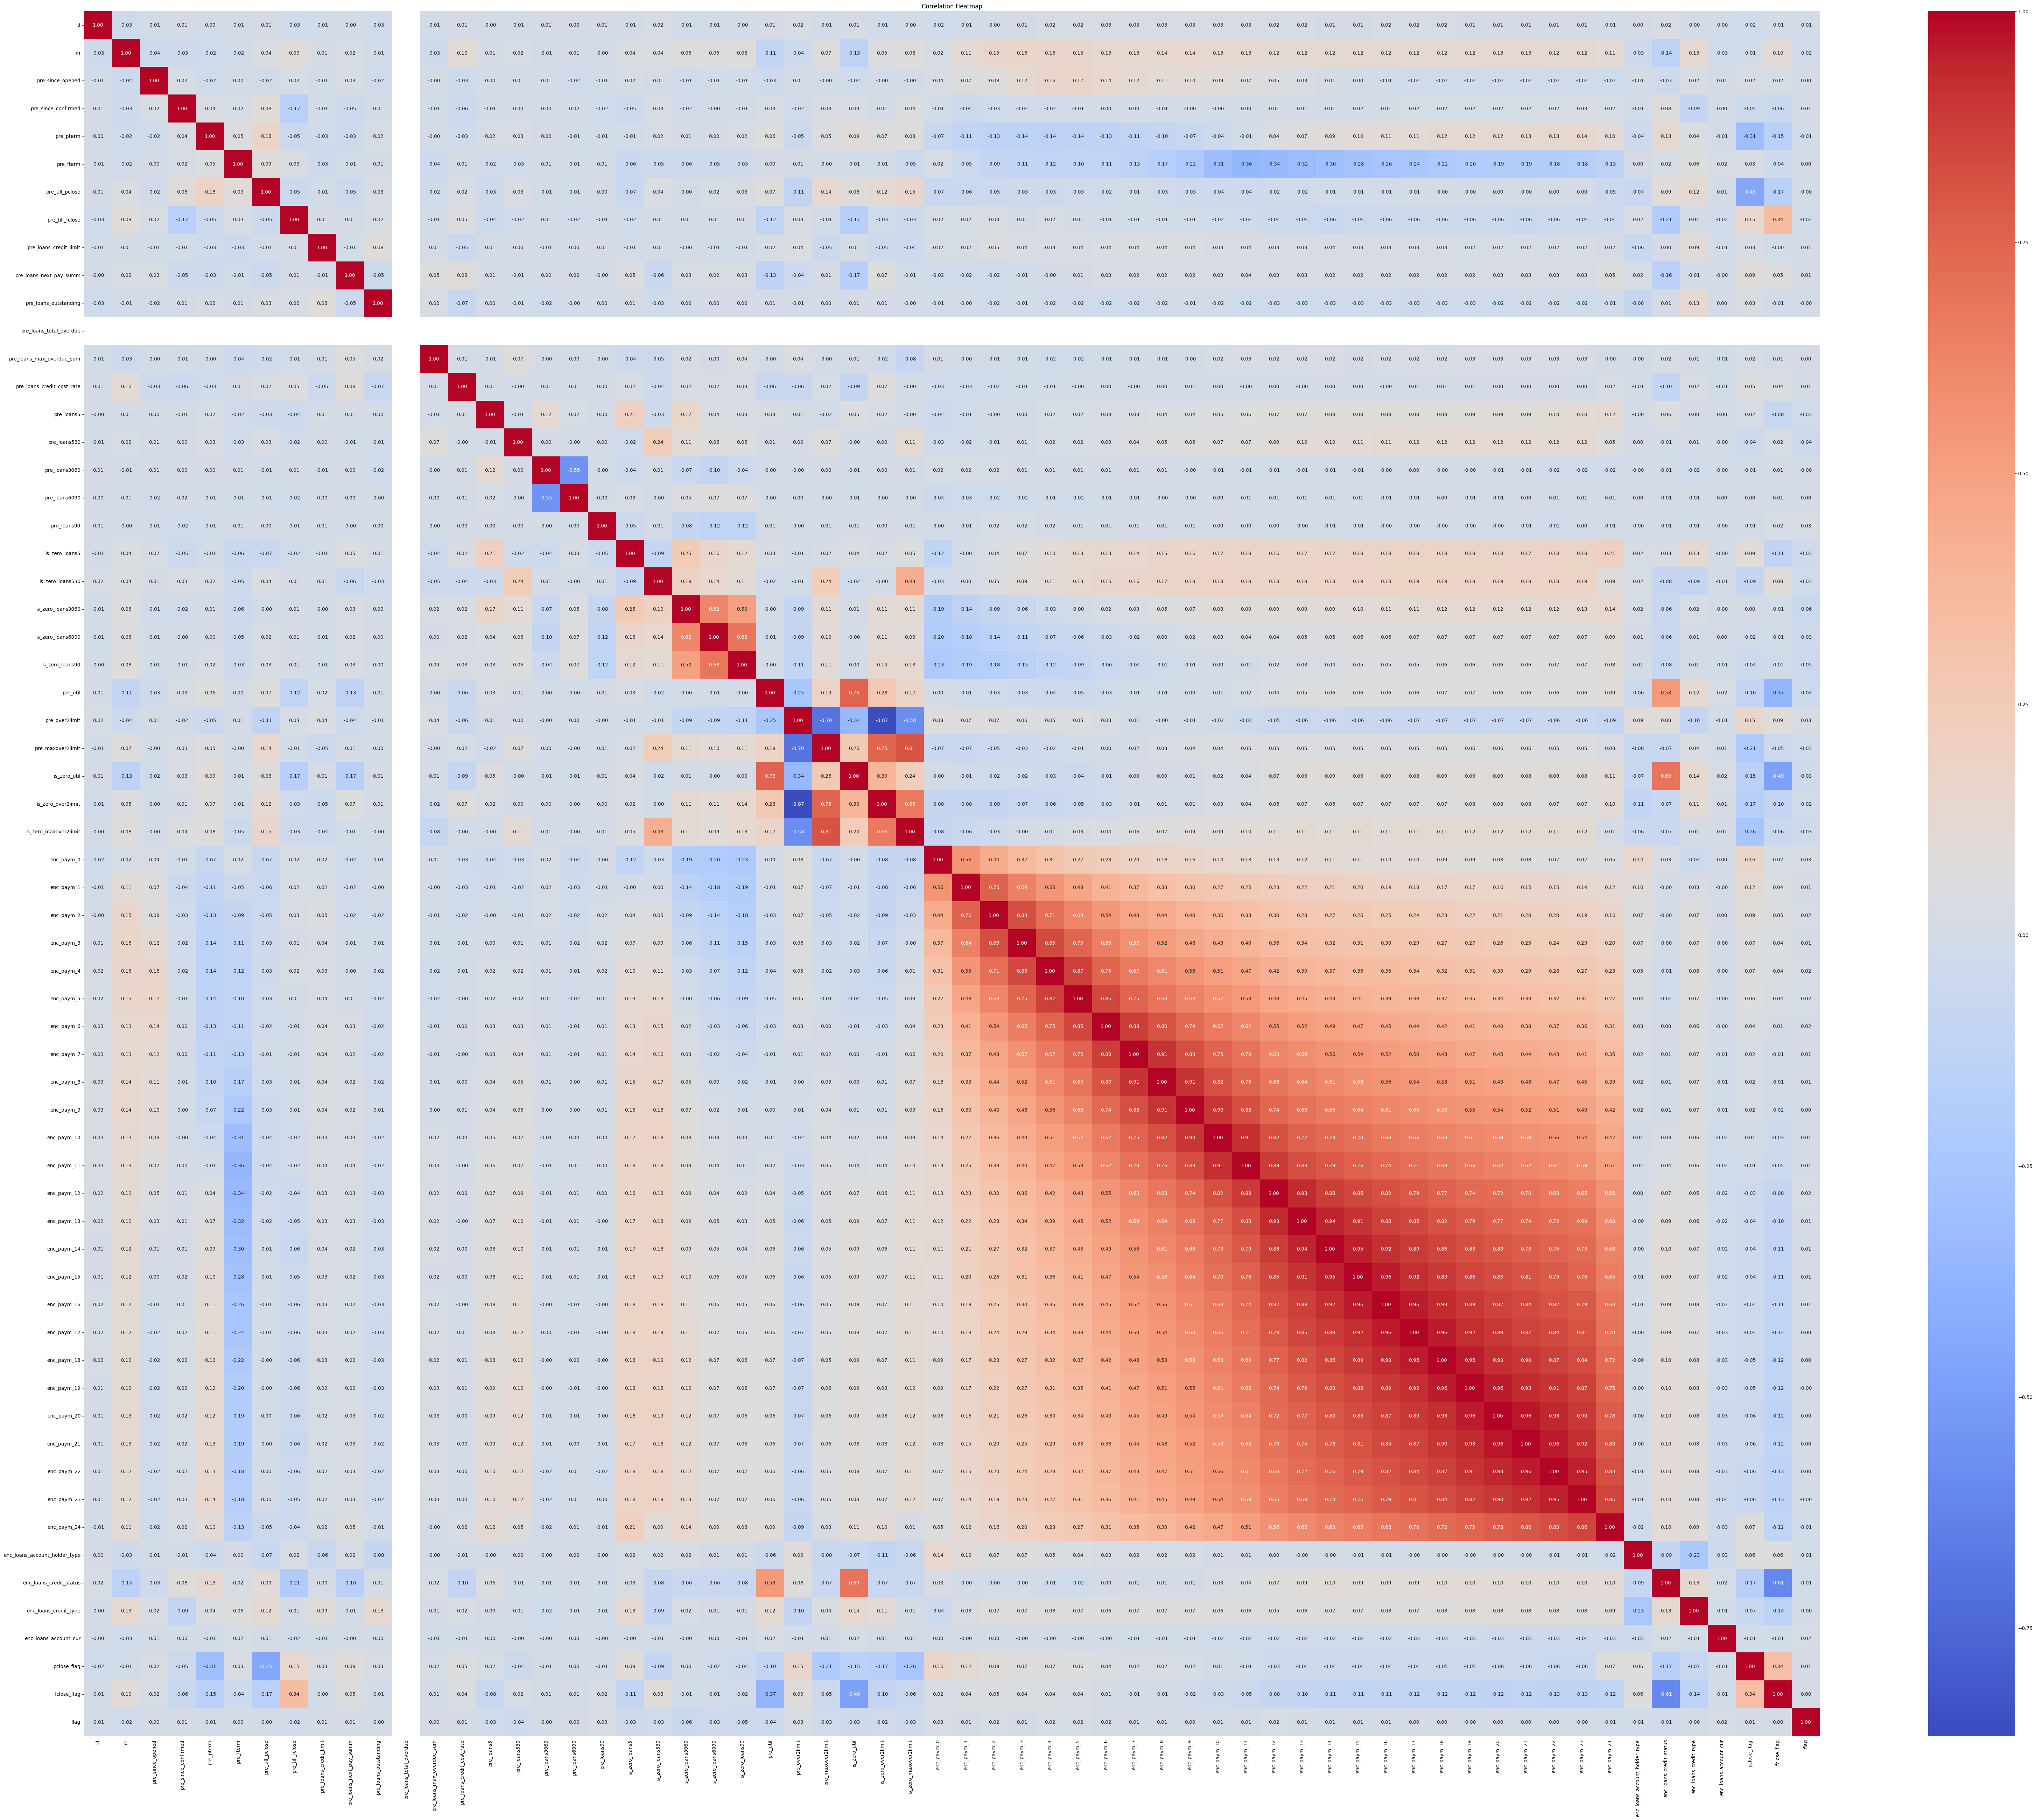

In [ ]:
# Вычисляем матрицу корреляции
corr_matrix = cutting_dataset_3.corr()

# Создаем тепловую карту
plt.figure(figsize=(80, 64))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Во всех трех матрицах показывает примерно одинаковые цифры корреляции из матрицы видно что столбцы нашего датасета оказывают минимальное влияние на целевую переменную flag

# 3 Data Preparation

Feature Engineering

Новые признаки

Добавим новые признаки в наш датасет :

Общее количество просроченных платежей за всю кредитную историю клиента
(total_overdue_payments'): Этот признак позволит оценить общую платежную дисциплину заявки.

Среднее количество дней просрочки платежей за всю кредитную историю клиента ('average_days_overdue'): Этот признак позволит определить среднюю продолжительность просрочки платежей, что также важно для оценки платежной дисциплины заявки

In [ ]:
# Создание признака: Общее количество просроченных платежей за всю кредитную историю клиента
merged_data ['total_overdue_payments'] = merged_data ['pre_loans5'] + merged_data ['pre_loans530'] + merged_data ['pre_loans3060'] + merged_data ['pre_loans6090'] + merged_data['pre_loans90']

# Создание признака: Среднее количество дней просрочки платежей за всю кредитную историю клиента
merged_data ['average_days_overdue'] = (merged_data ['pre_loans5'] * 2.5 + merged_data ['pre_loans530'] * 17.5 + merged_data ['pre_loans3060'] * 45 +
                              merged_data ['pre_loans6090'] * 75 + merged_data ['pre_loans90'] * 120) / merged_data ['total_overdue_payments']


In [ ]:
merged_data.head()

id  rn  pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
0   0   1                18                    9          2          3   
1   0   2                18                    9         14         14   
2   0  10                 7                    9          2         10   
3   0   4                 4                    1          9         12   
4   1  13                 7                    9          4          8   

   pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
0               16               10                      11   
1               12               12                       0   
2                8                8                      16   
3               16                7                      12   
4                1               11                       1   

   pre_loans_next_pay_summ  ...  enc_paym_24  enc_loans_account_holder_type  \
0                        3  ...            4                              1   
1                        3  ...            4                              1   
2                        4  ...            4                              1   
3                        2  ...            4                              1   
4                        1  ...            4                              1   

   enc_loans_credit_status  enc_loans_credit_type  enc_loans_account_cur  \
0                        3                      4                      1   
1                        3                      4                      1   
2                        2                      4                      1   
3                        3                      1                      1   
4                        2                      3                      1   

   pclose_flag  fclose_flag  flag  total_overdue_payments  \
0            0            0     0                      39   
1            0            0     0                      39   
2            0            0     0                      39   
3            0            0     0                      39   
4            1            1     0                      39   

   average_days_overdue  
0             45.641026  
1             45.641026  
2             45.641026  
3             45.641026  
4             45.641026  

[5 rows x 64 columns]

In [ ]:
# Вычисление корреляции между новыми признаками и целевой переменной
correlation_total_overdue = merged_data['total_overdue_payments'].corr(merged_data['flag'])
correlation_average_days_overdue = merged_data ['average_days_overdue'].corr(merged_data ['flag'])

print("Корреляция между общим количеством просроченных платежей и целевой переменной flag:", correlation_total_overdue)
print("Корреляция между средним количеством дней просрочки и целевой переменной flag:", correlation_average_days_overdue)

Корреляция между общим количеством просроченных платежей и целевой переменной flag: -0.012433075302351684
Корреляция между средним количеством дней просрочки и целевой переменной flag: 0.012492517207427983


Корреляция близка к нулю можно сделать вывод что новые признаки не имеют большого влияния на целевую переменную flag

# 4 Сохраняем и загружаем датасет

In [ ]:
# Количество строк
merged_data.shape

(3000000, 64)

In [ ]:
drive.mount('/content/drive')

# Путь к файлу на Google Диске
file_path = '/content/drive/My Drive/merged_data.csv'

# Сохранение в формате CSV
merged_data.to_csv(file_path, index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Путь к файлу на Google Диске
file_path = '/content/drive/My Drive/merged_data.csv'

# Чтение файла CSV
loaded_data = pd.read_csv(file_path)

# Вывод первых нескольких строк для проверки
loaded_data.head()


id  rn  pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
0   0   1                18                    9          2          3   
1   0   2                18                    9         14         14   
2   0  10                 7                    9          2         10   
3   0   4                 4                    1          9         12   
4   1  13                 7                    9          4          8   

   pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
0               16               10                      11   
1               12               12                       0   
2                8                8                      16   
3               16                7                      12   
4                1               11                       1   

   pre_loans_next_pay_summ  ...  enc_paym_24  enc_loans_account_holder_type  \
0                        3  ...            4                              1   
1                        3  ...            4                              1   
2                        4  ...            4                              1   
3                        2  ...            4                              1   
4                        1  ...            4                              1   

   enc_loans_credit_status  enc_loans_credit_type  enc_loans_account_cur  \
0                        3                      4                      1   
1                        3                      4                      1   
2                        2                      4                      1   
3                        3                      1                      1   
4                        2                      3                      1   

   pclose_flag  fclose_flag  flag  total_overdue_payments  \
0            0            0     0                      39   
1            0            0     0                      39   
2            0            0     0                      39   
3            0            0     0                      39   
4            1            1     0                      39   

   average_days_overdue  
0             45.641026  
1             45.641026  
2             45.641026  
3             45.641026  
4             45.641026  

[5 rows x 64 columns]

In [ ]:
# Количество строк
loaded_data.shape

(3000000, 64)

# 5 Метод линейной регрессии

In [ ]:
# Определение признаков и целевой переменной
X = loaded_data.drop(columns=['flag'])
y = loaded_data['flag']

# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class AutomatedPipeline:
    def __init__(self, numeric_features, model):
        self.numeric_features = numeric_features
        self.model = model
        self.pipeline = self._create_pipeline()

    def _create_pipeline(self):
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, self.numeric_features)
            ]
        )

        return Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', self.model)
        ])

    def fit(self, X, y):
        self.pipeline.fit(X, y)

    def predict(self, X):
        return self.pipeline.predict(X)

# Определение числовых признаков
numeric_features = ['pre_since_opened']

# Создание экземпляра модели
model = LinearRegression()

# Создание и обучение автоматизированного пайплайна
automated_pipeline = AutomatedPipeline(numeric_features, model)
automated_pipeline.fit(X_train, y_train)

# Предсказание на тестовых данных
predictions = automated_pipeline.predict(X_test)

# Сохранение обученной модели
with open('/content/drive/My Drive/automated_pipeline_model.pkl', 'wb') as f:
    pickle.dump(automated_pipeline, f)


In [ ]:
# Вычисление средней квадратичной ошибки
mse = mean_squared_error(y_test, predictions)

# Вычисление средней абсолютной ошибки
mae = mean_absolute_error(y_test, predictions)

# Вычисление коэффициента детерминации
r2 = r2_score(y_test, predictions)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R^2 Score:", r2)


Mean Squared Error: 0.028665108307987793
Mean Absolute Error: 0.0571568972115542
R^2 Score: 2.4834078688140693e-05


In [ ]:
# Вычисление ROC-AUC на тестовом наборе данных
roc_auc = roc_auc_score(y_test, predictions)

print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.5086994644359591


ROC-AUC Score 0.5086994644359591 для модели линейной регрессии указывает на то, что модель почти не лучше случайного угадывания. Это говорит о том, что текущая модель практически не способна различать классы.

Линейная регрессия может быть неподходящей для данной задачи. Возможно, целевая переменная или признаки требуют нелинейного подхода.

# 6 Модель случайного леса

In [ ]:
# Создание экземпляра модели случайного леса
rf_model = RandomForestRegressor()

# Создание и обучение автоматизированного пайплайна с моделью случайного леса
rf_automated_pipeline = AutomatedPipeline(numeric_features, rf_model)
rf_automated_pipeline.fit(X_train, y_train)

# Предсказание на тестовых данных с помощью обученного пайплайна
rf_predictions = rf_automated_pipeline.predict(X_test)

# Сохранение обученной модели случайного леса
with open('rf_automated_pipeline_model.pkl', 'wb') as f:
    pickle.dump(rf_automated_pipeline, f)


In [ ]:
# Обучение пайплайна с моделью случайного леса
rf_automated_pipeline.fit(X_train, y_train)

In [ ]:
# Предсказание на тестовых данных с помощью модели случайного леса
rf_predictions = rf_automated_pipeline.predict(X_test)
rf_predictions

array([0.04702845, 0.02620592, 0.04005126, ..., 0.04702845, 0.02321037,
       0.03645632])

In [ ]:
# Вычисление ROC-AUC
roc_auc_rf = roc_auc_score(y_test, rf_predictions)
print("ROC-AUC Score:", roc_auc_rf)

ROC-AUC Score: 0.5787478793374536


Такая же ситуатция и с моделью случайного леса

# 7 Неиронные сети

In [ ]:
class AutomatedPipeline:
    def __init__(self, numeric_features, model):
        self.numeric_features = numeric_features
        self.model = model
        self.pipeline = self._create_pipeline()

    def _create_pipeline(self):
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, self.numeric_features)
            ]
        )

        return Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', self.model)
        ])

    def fit(self, X, y):
        self.pipeline.fit(X, y)

    def predict(self, X):
        return self.pipeline.predict(X)

# Определение числовых признаков
numeric_features = ['pre_since_opened']

# Создание экземпляра модели нейронной сети
model = Sequential([
    Dense(64, activation='relu', input_shape=(len(numeric_features),)),
    Dense(64, activation='relu'),
    Dense(1)  # Выходной слой с одним нейроном (регрессия)
])

# Компиляция модели
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Создание и обучение автоматизированного пайплайна
neural_net_pipeline = AutomatedPipeline(numeric_features, model)
neural_net_pipeline.fit(X_train, y_train)

# Предсказание на тестовых данных
predictions = neural_net_pipeline.predict(X_test)

# Сохранение обученной модели
with open('neural_net_pipeline_model.pkl', 'wb') as f:
    pickle.dump(neural_net_pipeline, f)

18750/18750 [==============================] - 26s 1ms/step


In [ ]:
automated_pipeline.fit(X_train, y_train)

In [ ]:
predictions = automated_pipeline.predict(X_test)
predictions

array([0.03091399, 0.0285095 , 0.0289904 , ..., 0.03091399, 0.0278683 ,
       0.02931099])

In [ ]:
# Вычисление ROC-AUC
roc_auc_nn = roc_auc_score(y_test, predictions)

print("ROC-AUC Score:", roc_auc_nn)

ROC-AUC Score: 0.5086994644359591


Низкий ROC-AUC Score: 0.5086994644359591 возможно данная модель не подходит

# 8 Модель случайного леса


Попробуем улучшить модель случаиного леса подобрав гиперпараметры т к у него самый высокий ROC-AUC Score

In [ ]:
# Путь к файлу на Google Диске
file_path = '/content/drive/My Drive/merged_data.csv'

# Чтение файла CSV
loaded_data = pd.read_csv(file_path)

# Выберим первые 10000 строк в новый датафреим

optimized_dataset = loaded_data.head(10000)
optimized_dataset

id  rn  pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
0        0   5                 5                   12         15          2   
1        0   7                 3                    9          1          2   
2        0   4                 4                    1          9         12   
3        0  10                 7                    9          2         10   
4        0   8                 2                    9          2          3   
...    ...  ..               ...                  ...        ...        ...   
9995  1782   7                 5                   13          8          6   
9996  1782   1                 8                    7          7          6   
9997  1782  13                 3                    3         16          9   
9998  1783   9                 7                    2         14          7   
9999  1783   3                13                   14          9          9   

      pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
0                  11               12                      10   
1                  12               14                      15   
2                  16                7                      12   
3                   8                8                      16   
4                  12               14                      15   
...               ...              ...                     ...   
9995               16                7                       3   
9996                4                9                       5   
9997               15               14                      12   
9998               10                4                      17   
9999                3                5                       3   

      pre_loans_next_pay_summ  ...  enc_paym_24  \
0                           2  ...            4   
1                           5  ...            4   
2                           2  ...            4   
3                           4  ...            4   
4                           5  ...            4   
...                       ...  ...          ...   
9995                        2  ...            4   
9996                        2  ...            4   
9997                        2  ...            4   
9998                        2  ...            4   
9999                        2  ...            4   

      enc_loans_account_holder_type  enc_loans_credit_status  \
0                                 1                        3   
1                                 1                        3   
2                                 1                        3   
3                                 1                        2   
4                                 1                        3   
...                             ...                      ...   
9995                              1                        3   
9996                              1                        3   
9997                              1                        3   
9998                              1                        3   
9999                              1                        3   

      enc_loans_credit_type  enc_loans_account_cur  pclose_flag  fclose_flag  \
0                         4                      1            0            0   
1                         4                      1            0            0   
2                         1                      1            0            0   
3                         4                      1            0            0   
4                         4                      1            0            0   
...                     ...                    ...          ...          ...   
9995                      1                      1            0            0   
9996                      4                      1            0            0   
9997                      4                      1            0            0   
9998                      4                      1            0            0   
9999

In [ ]:
# Определение признаков и целевой переменной
X = optimized_dataset.drop(columns=['flag'])
y = optimized_dataset['flag']

# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Задание сетки гиперпараметров для перебора
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Создание экземпляра модели случайного леса
rf_model = RandomForestRegressor()

# Создание экземпляра GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=2)

# Поиск оптимальных гиперпараметров
grid_search.fit(X_train, y_train)

# Вывод наилучших гиперпараметров
print("Наилучшие гиперпараметры:", grid_search.best_params_)

# Предсказание на тестовых данных с помощью модели с лучшими гиперпараметрами
best_rf_model = grid_search.best_estimator_
best_rf_predictions = best_rf_model.predict(X_test)

# Вычисление ROC-AUC с использованием модели с лучшими гиперпараметрами
roc_auc_best_rf = roc_auc_score(y_test, best_rf_predictions)
print("ROC-AUC Score для модели с лучшими гиперпараметрами:", roc_auc_best_rf)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   4.0s
[CV] END max_depth=None, min_samples_split=2, n_estimators=150; total time=   5.5s
[CV] END max_depth=None, min_samples_split=2, n_estimators=150; total time=   5.0s
[CV] END max_depth=None, min_samples_split=2, n_estimators=150; total time=   6.0s
[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time=   2.0s
[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END max_depth=None, min_sa

In [ ]:
# Путь к файлу на Google Диске
file_path = '/content/drive/My Drive/merged_data.csv'

# Чтение файла CSV
loaded_data = pd.read_csv(file_path)

# Выберем  до 100000
optimized_dataset_2 = loaded_data.head(100000)
optimized_dataset_2

# Определение признаков и целевой переменной
X = optimized_dataset_2.drop(columns=['flag'])
y = optimized_dataset_2['flag']

# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Путь к файлу на Google Диске
file_path = '/content/drive/My Drive/merged_data.csv'

# Чтение файла CSV
loaded_data = pd.read_csv(file_path)

# Выберем от 100000 до 200000
optimized_dataset_3 = loaded_data.iloc[100000:200000]
optimized_dataset_3

# Определение признаков и целевой переменной
X = optimized_dataset_3.drop(columns=['flag'])
y = optimized_dataset_3['flag']

# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Определение признаков и целевой переменной
X = optimized_dataset_2.drop(columns=['flag'])
y = optimized_dataset_2['flag']

# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание модели случайного леса с наилучшими гиперпараметрами
best_rf_model = RandomForestRegressor(n_estimators=150, max_depth=20, min_samples_split=5)

# Обучение модели на тренировочных данных
best_rf_model.fit(X_train, y_train)

# Оценка модели на тренировочных данных
train_predictions = best_rf_model.predict(X_train)
roc_auc_train = roc_auc_score(y_train, train_predictions)

# Оценка модели на тестовых данных
test_predictions = best_rf_model.predict(X_test)
roc_auc_test = roc_auc_score(y_test, test_predictions)

print("ROC-AUC Score на тренировочных данных:", roc_auc_train)
print("ROC-AUC Score на тестовых данных:", roc_auc_test)


ROC-AUC Score на тренировочных данных: 0.9986571927547492
ROC-AUC Score на тестовых данных: 0.7739201763682427


In [ ]:
# Определение признаков и целевой переменной
X = optimized_dataset_3.drop(columns=['flag'])
y = optimized_dataset_3['flag']

# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание модели случайного леса с наилучшими гиперпараметрами
best_rf_model = RandomForestRegressor(n_estimators=150, max_depth=20, min_samples_split=5)

# Обучение модели на тренировочных данных
best_rf_model.fit(X_train, y_train)

# Оценка модели на тренировочных данных
train_predictions = best_rf_model.predict(X_train)
roc_auc_train = roc_auc_score(y_train, train_predictions)

# Оценка модели на тестовых данных
test_predictions = best_rf_model.predict(X_test)
roc_auc_test = roc_auc_score(y_test, test_predictions)

print("ROC-AUC Score на тренировочных данных:", roc_auc_train)
print("ROC-AUC Score на тестовых данных:", roc_auc_test)


ROC-AUC Score на тренировочных данных: 0.9992941104524621
ROC-AUC Score на тестовых данных: 0.7665526877987933


Наша модель демонстрирует высокое значение ROC-AUC на тренировочных данных (0.9992941104524621) и значительно более низкое на тестовых данных (0.7665526877987933), это явный признак переобучения. Модель слишком хорошо обучилась на тренировочных данных, включая шум и специфические особенности этих данных, что приводит к плохой обобщающей способности на новых данных.

In [ ]:
# Создание модели случайного леса с гиперпараметрами и регуляризацией
rf_model = RandomForestRegressor(
    n_estimators=150,
    max_depth=10,           # Уменьшение глубины дерева
    min_samples_split=10,   # Увеличение минимального количества выборок для разделения узла
    min_samples_leaf=4,     # Увеличение минимального количества выборок для листа
    max_features='sqrt',    # Ограничение количества признаков для каждого деления
    random_state=42
)

# Обучение модели
rf_model.fit(X_train, y_train)

# Оценка модели на тренировочных данных
train_predictions = rf_model.predict(X_train)
roc_auc_train = roc_auc_score(y_train, train_predictions)

# Оценка модели на тестовых данных
test_predictions = rf_model.predict(X_test)
roc_auc_test = roc_auc_score(y_test, test_predictions)

print("ROC-AUC Score на тренировочных данных:", roc_auc_train)
print("ROC-AUC Score на тестовых данных:", roc_auc_test)


ROC-AUC Score на тренировочных данных: 0.7726657842392266
ROC-AUC Score на тестовых данных: 0.6591146509537601


In [ ]:
# Создание модели случайного леса с регуляризацией
best_rf_model = RandomForestRegressor(
    n_estimators=150,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=4,  # Добавление минимального количества листьев
    max_features='sqrt'  # Ограничение количества признаков для каждого деления
)

# Обучение модели
best_rf_model.fit(X_train, y_train)

# Оценка модели
train_predictions = best_rf_model.predict(X_train)
roc_auc_train = roc_auc_score(y_train, train_predictions)
test_predictions = best_rf_model.predict(X_test)
roc_auc_test = roc_auc_score(y_test, test_predictions)

print("ROC-AUC Score на тренировочных данных:", roc_auc_train)
print("ROC-AUC Score на тестовых данных:", roc_auc_test)


ROC-AUC Score на тренировочных данных: 0.976688761367297
ROC-AUC Score на тестовых данных: 0.6587576151003696


Наша модель демонстрирует высокое значение ROC-AUC на тренировочных данных (0.9766887613672972) и значительно более низкое на тестовых данных (0.6587576151003696), это явный признак переобучения. Модель слишком хорошо обучилась на тренировочных данных, включая шум и специфические особенности этих данных, что приводит к плохой обобщающей способности на новых данных.

Модель переобучена

# 9 XGBoost (Extreme Gradient Boosting)

XGBoost (Extreme Gradient Boosting) является мощным алгоритмом для задач классификации и регрессии, который значительно улучшает производительность за счет использования множества продвинутых методов и приемов. Ниже рассмотрим основные аспекты и возможности XGBoost, а также пример использования с гиперпараметрами и регуляризацией.

Основные Аспекты XGBoost
Boosting: XGBoost использует метод градиентного бустинга, где слабые модели (деревья решений) строятся последовательно, каждая из которых исправляет ошибки предыдущей.

Регуляризация: В XGBoost встроены методы регуляризации (L1 и L2), которые помогают предотвратить переобучение. Это одна из ключевых отличительных черт, делающих XGBoost более устойчивым по сравнению с другими бустинговыми алгоритмами.

Параллельная Обработка: XGBoost поддерживает параллельную обработку для ускорения процесса обучения.

Устойчивость к Пропущенным Значениям: XGBoost может обрабатывать пропущенные значения, автоматически обучаясь, какие пути выбирать при наличии пропусков в данных.

Кросс-Валидация: Встроенная поддержка кросс-валидации для оценки качества модели на тренировочных данных.

In [ ]:
# Путь к файлу на Google Диске
file_path = '/content/drive/My Drive/merged_data.csv'

# Чтение файла CSV
loaded_data = pd.read_csv(file_path)

# Выберем  до 10000
optimized_dataset_10 = loaded_data.head(10000)
optimized_dataset_10

# Определение признаков и целевой переменной
X = optimized_dataset_10.drop(columns=['flag'])
y = optimized_dataset_10['flag']

# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определение модели XGBoost
xgb_model = XGBClassifier()

# Задание сетки гиперпараметров для перебора
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Создание экземпляра RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=10,
    cv=3,
    scoring='roc_auc',
    verbose=2,
    n_jobs= 1,
    random_state=42
)

# Поиск оптимальных гиперпараметров
random_search.fit(X_train, y_train)

# Вывод наилучших гиперпараметров
print("Наилучшие гиперпараметры:", random_search.best_params_)

# Вывод наилучшего значения ROC-AUC
print("Наилучшие значения ROC-AUC:", random_search.best_score_)

# Оценка модели на тестовом наборе данных
best_model = random_search.best_estimator_
test_predictions = best_model.predict_proba(X_test)[:, 1]
test_score = roc_auc_score(y_test, test_predictions)
print("Значение ROC-AUC на тестовом наборе данных:", test_score)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=9, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=9, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=9, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=9, n_estimators=100, subsample=0.8; total time=   3.9s
[CV] END learning_rate=0.2, max_depth=9, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=9, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END

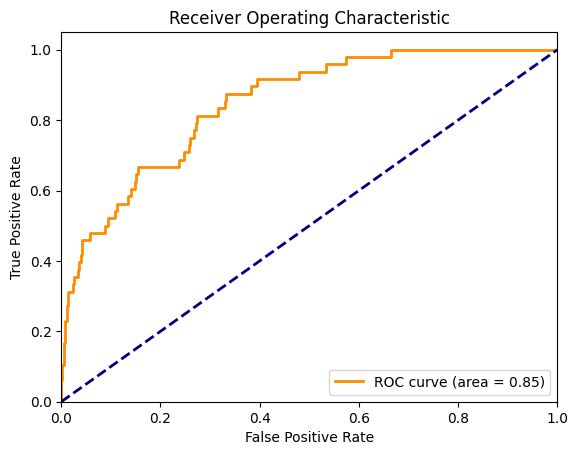

In [ ]:
# Вычисление ROC кривой
fpr, tpr, thresholds = roc_curve(y_test, test_predictions)
roc_auc = auc(fpr, tpr)

# Построение ROC кривой
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Сравнение ROC-AUC на тренировочном и тестовом наборах данных показывает, что модель не сильно переобучена (overfitted), так как производительность на тестовом наборе данных даже выше, чем на тренировочном.

ROC кривая отображает зависимость между долей ложноположительных срабатываний и долей истинно положительных срабатываний.
Чем ближе ROC кривая к верхнему левому углу, тем лучше модель.






# 10  Сохранение результатов

In [ ]:
# Подключение к Google Диску
drive.mount('/content/drive')

# Создание папки для сохранения результатов на Google Диске
save_path = '/content/drive/My Drive/xgb_model_results'
os.makedirs(save_path, exist_ok=True)

# Сохранение обученной модели на Google Диск
model_path = os.path.join(save_path, 'best_xgb_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

# Сохранение предсказаний на тестовой выборке на Google Диск
predictions_path = os.path.join(save_path, 'xgb_predictions.csv')
predictions_df.to_csv(predictions_path, index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
